In [2]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

In [31]:
dp_mix_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    
    array[I] vector[T] y; // value of interest
    array[I] matrix[T,P+1] X; // covariates matrices for each province
      
    // hyperpar vector of regressors
    vector[P+1] mu_0; 
    real        sigma_0;
    
    // mean of w_1 (random effect for every province at time 1)
    vector[I] mu_w_1;
    
    // tau^2
    real a_tau2;
    real b_tau2;
    
    // sigma^2
    real a_sigma2;
    real b_sigma2;
    
    // proximity matrix
    matrix[I,I] W_raw;
    
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
}

parameters
{
    real<lower=0> sigma2; 
    real<lower=0> tau2; 
    real<lower=0,upper=1> rho_t;
    real<lower=0,upper=1> rho_s;
    
    // beta
    vector[P+1] beta;

    // for the random effect construction 
    array[T] vector[I] w_raw;
}

transformed parameters
{   
    // Stan wants std
    real sigma = sqrt(sigma2);
    real tau = sqrt(tau2);
    
    matrix[I,I] inv_Q = inverse_spd(rho_s*W + (1-rho_s)*eye_I);
    
    matrix[I, I] L;
    L = cholesky_decompose(inv_Q);
    
     // random effects tmp
    matrix[I,T]                ws_tmp;
    
    ws_tmp[1:I,1] =  mu_w_1 + L*w_raw[1];
    
    for (t in 2:T)
        ws_tmp[1:I,t] = rho_t*ws_tmp[1:I,t-1] + L*w_raw[t]; 
    
    matrix[T,I]   ws = (ws_tmp)'; //otherwise I have to transpose in the for loop at each iteration
}

model
{
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2); 
    rho_t  ~ uniform(0,1);
    rho_s  ~ uniform(0,1);
    
    w_raw[1] ~ normal(0, tau); 
    
    for (t in 2:T)
        w_raw[t] ~ normal(0, tau);
    
    beta ~ normal(mu_0, sigma_0);
    
    for (i in 1:I) {
        
        y[i] ~ normal(X[i]*beta + ws[1:T,i], sigma);
    
    }
}

generated quantities 
{   
    // log likelihood for each areal location 
    vector[I] log_lik;
    
    for (i in 1:I) 
    {
        log_lik[i] = normal_lpdf(y[i] | X[i]*beta + ws[1:T,i], sigma);
    }
    
}
"""

stan_file = "Sp_corr.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

14:55:29 - cmdstanpy - INFO - compiling stan file /home/riccardo/bayesian-project/Sp_corr.stan to exe file /home/riccardo/bayesian-project/Sp_corr
14:56:09 - cmdstanpy - INFO - compiled model executable: /home/riccardo/bayesian-project/Sp_corr


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
with open("fecondità_finale", "rb") as f:
    dataset=pd.read_csv(f)
    
dataset = dataset.sort_values(by=['Territorio', 'TIME']) # the proximity matrix is built with the prov in alphabetic order

0.015125712353150588
1.3187169811320756
[[1.37 1.35 1.27 ... 1.29 1.24 1.26]
 [1.37 1.36 1.3  ... 1.22 1.17 1.15]
 [1.44 1.43 1.36 ... 1.24 1.21 1.21]
 ...
 [1.28 1.36 1.24 ... 1.29 1.25 1.3 ]
 [1.51 1.53 1.47 ... 1.39 1.33 1.34]
 [1.31 1.31 1.23 ... 1.2  1.11 1.09]]
(106, 10)


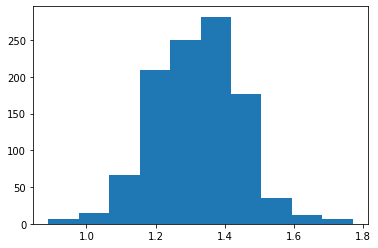

In [15]:
Y=np.array(dataset["tasso.di.fecondità.totale"])

print(np.var(Y))
print(np.mean(Y))


y = []
y_tmp = np.zeros(10)
for prov in np.unique(dataset["Territorio"]):
    data_prov = dataset[dataset["Territorio"] == prov]
    y_tmp = np.array(data_prov["tasso.di.fecondità.totale"])
    y.append(y_tmp)
y = np.array(y)
print(y)
print(y.shape)
plt.hist(Y)  
plt.show()

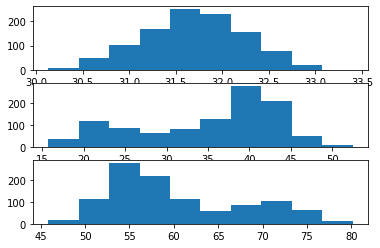

In [16]:
X1=np.array(dataset["età.media.delle.madri.al.parto"])
X2=np.array(dataset["tasso.di.occupazione.delle.femmine"])
X3=np.array(dataset["tasso.di.inattività.delle.femmine"])
fig,axs = plt.subplots(3)
axs[0].hist(X1)
axs[1].hist(X2)
axs[2].hist(X3)
plt.show()

[[[ 1.       30.94     19.828757 75.561168]
  [ 1.       30.73     20.513632 74.366121]
  [ 1.       31.09     19.889053 73.567265]
  ...
  [ 1.       31.6      17.657712 72.894657]
  [ 1.       31.54     20.233052 72.657509]
  [ 1.       31.68     19.605443 73.588625]]

 [[ 1.       30.8      39.451928 57.574233]
  [ 1.       31.       40.164516 54.810388]
  [ 1.       31.3      36.393676 57.093995]
  ...
  [ 1.       31.59     38.993238 56.520048]
  [ 1.       31.72     37.393056 57.636515]
  [ 1.       31.76     36.56961  58.716203]]

 [[ 1.       31.25     41.99944  53.959666]
  [ 1.       31.37     40.624724 54.142564]
  [ 1.       31.46     40.848654 53.062674]
  ...
  [ 1.       32.26     41.319976 53.56965 ]
  [ 1.       32.24     41.867732 52.173954]
  [ 1.       32.29     40.33348  55.326854]]

 ...

 [[ 1.       31.22     23.356139 72.17985 ]
  [ 1.       31.18     21.612323 73.166793]
  [ 1.       31.32     22.219573 70.285546]
  ...
  [ 1.       31.54     24.605974 70.2802

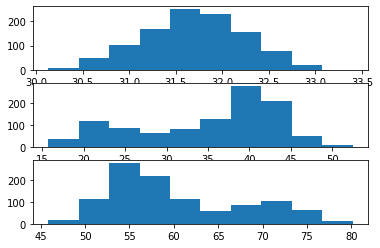

In [18]:
P = 3
X=np.ones((1060,P+1))

X[:,1]=X1

X[:,2]=X2

X[:,3]=X3

X_r = np.reshape(X,(106,10,P+1))

print(X_r)
X_r.shape

fig,axs = plt.subplots(3)
axs[0].hist(X1)
axs[1].hist(X2)
axs[2].hist(X3)
plt.show()

In [19]:
I= 106
T= 10
H= 10

In [20]:
with open("proximity_matrix", "rb") as f:
    W_raw=pd.read_csv(f)

In [21]:
W_raw=np.matrix(W_raw)

In [24]:
for i in range(106):
  W_raw[i,i] = 0

In [25]:
mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper
sigma_0 = 1 #covariance matrix
H = 10

data = {
    "I": I,
    "T": T,
    "P": P,
    "y": y,
    "X": X_r,
    "mu_0": mu_0,
    "sigma_0": sigma_0,
    "mu_w_1": mu_w_1,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "W_raw": W_raw
}

In [ ]:
fit = dp_mix.sample(data
                    , iter_warmup = 2000
                    , iter_sampling = 2000)